In [1]:
%config Completer.use_jedi = False

import os
import platform
from collections import namedtuple
import time

from tqdm.notebook import tqdm
import tabulate

import pandas as pd
import numpy as np
import sparse

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import _LRScheduler
# from torchvision import transforms
# from torchsummary import summary
# from efficientnet_pytorch_3d import EfficientNet3D
from my_efficientnet_pytorch_3d import EfficientNet3D
import torchio

from torch.utils.tensorboard import SummaryWriter

from utils import CTDataset


########################

RUNNING_IN_KAGGLE = 'linux' in platform.platform().lower()
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progression/" if RUNNING_IN_KAGGLE else 'data/'
PROCESSED_PATH = 'FIX IT!' if RUNNING_IN_KAGGLE else 'data/processed-data/'  # TODO: fix this line

dtype = torch.float32
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
device = torch.device(device)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [2]:
class VGG(torch.nn.Module):
    _vgg_configurations = {
        'small': [8, 'M', 8, 'M', 16, 'M', 16, 'M'],
        8: [64, 'M', 128, 'M', 256, 'M', 512, 'M', 512, 'M'],
        11: [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        13: [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        16: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        19: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }

    @staticmethod
    def _make_layers(cfg, batch_norm):
        layers = []
        in_channels = 1
        for v in cfg:
            if v == 'M':
                layers += [torch.nn.MaxPool3d(kernel_size=2, stride=2)]
            else:
                layers += [torch.nn.Conv3d(in_channels, v, kernel_size=3, padding=1)]
                if batch_norm:
                    layers += [torch.nn.BatchNorm3d(v)]
                layers += [torch.nn.ReLU(inplace=True)]
                in_channels = v
        return layers

    def __init__(self, VGG_version, batch_norm):
        super().__init__()
        self.VGG_version = VGG_version
        self.batch_norm = batch_norm
        
        self.net = nn.Sequential(
            *VGG._make_layers(self._vgg_configurations[VGG_version], batch_norm)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor):
        return self.net(x)

In [3]:
class LaplaceLoss(nn.Module):  # _Loss):
    def forward(self, y_true, preds, log_sigma, metric=False):
        abs_diff = (y_true - preds).abs()

        log_sigma.clamp_(-np.log(70), np.log(70))

        if metric:
            abs_diff.clamp_max_(1000)

        losses = np.sqrt(2) * abs_diff / log_sigma.exp() + log_sigma + np.log(2) / 2
        return losses.mean()


class PinballLoss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = torch.tensor(alpha, dtype=torch.float32)

    def forward(self, y, z):
        return torch.max((y - z) * self.alpha, (z - y) * (1 - self.alpha)).mean()

In [4]:
class SqueezeLayer(nn.Module):
    def forward(self, x):
        return x.squeeze()


class FeatureExtractor(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, x):
        return self.net.extract_features(x)


class OSICNet(nn.Module):
    FVC_MEAN, FVC_STD = 2690.479018721756, 832.5021066817238

    def __init__(self, dtype, device, use_poly, use_quantiles, efficient_net_model_number, hidden_size, dropout_rate):  # , output_size
        super().__init__()

        self.dtype = dtype
        self.device = device

        self.use_poly = use_poly
        self.use_quantiles = use_quantiles
        assert not (self.use_poly and self.use_quantiles)

        self.CT_features_extractor = nn.Sequential(
            FeatureExtractor(
                EfficientNet3D.from_name(
                    f'efficientnet-b{efficient_net_model_number}', override_params={'num_classes': 1}, in_channels=1
                )
            ),
#             VGG('small', True),
            nn.AdaptiveAvgPool3d(1),
            SqueezeLayer()
        )

        self.predictor = nn.Sequential(
            nn.Linear(15 + (1 - self.use_poly), hidden_size),  # 1280  # 16 + 
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, (5 if self.use_poly else 2) + self.use_quantiles)  # poly coefs & sigma or FVC & log_sigma
        )

        self._initialize_weights()

        self.CT_features_extractor.to(self.device)
        self.predictor.to(self.device)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def _prepare_data(self, data):
        data = list(data)
        if data[0].ndim >= 2:
            for i in range(len(data)):
                data[i] = data[i].squeeze(0)

        percents, weeks, FVCs, features, masks, images = data

#         lungs_mean, lungs_std = -971.4692260919278, 117.84143467421829
#         lungs = -1000 * (1.0 - masks) + masks * images
#         lungs = (lungs - lungs_mean) / lungs_std
#         lungs = lungs.type(self.dtype)
        lungs = None
        images = None

        percents_mean, percents_std = 77.6726, 19.8233
        weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002

        percents = (percents - percents_mean) / percents_std
        weeks = (weeks - weeks_mean) / weeks_std
        FVCs = (FVCs - self.FVC_MEAN) / self.FVC_STD
        features = features.type(self.dtype)
        
        return percents, weeks, FVCs, features, lungs, images

    def forward(self, data):
        weeks_unnorm = data[1]
        percents, weeks, FVCs, features, lungs, images = self._prepare_data(data)

#         lungs = lungs.unsqueeze(0).to(self.device)
#         lungs_features = self.CT_features_extractor(lungs)

        all_preds = []
        for base_percent, base_week, base_FVC in zip(percents, weeks, FVCs):
            table_features = torch.cat([
                torch.tensor([base_percent]),
                torch.tensor([base_week]),
                torch.tensor([base_FVC]),
                features
            ]).to(self.device)

            all_features = table_features  # torch.cat([lungs_features, table_features])
            
            if self.use_poly:
                X = all_features
            else:
                X = torch.cat([all_features.repeat(weeks.shape[0], 1), weeks.unsqueeze(1).to(self.device)], dim=1)

            preds = self.predictor(X).cpu()

            if self.use_poly:
                weeks_poly = torch.empty(len(weeks), 4, dtype=self.dtype)
                weeks_poly[:, 0] = weeks_unnorm ** 3
                weeks_poly[:, 1] = weeks_unnorm ** 2
                weeks_poly[:, 2] = weeks_unnorm
                weeks_poly[:, 3] = 1

                coefs = preds[:4]
                log_sigmas = preds[4]

                FVC_preds = (weeks_poly * coefs).sum(dim=1)
                log_sigmas = log_sigmas.repeat(FVC_preds.shape[0])
            else:
                if self.use_quantiles:
                    FVC_low, FVC_preds, FVC_high = preds.transpose(0, 1) * self.FVC_STD + self.FVC_MEAN
                    all_preds.append((FVC_low, FVC_preds, FVC_high))
                    continue
                FVC_preds, log_sigmas = preds.transpose(0, 1)

            FVC_preds = FVC_preds * self.FVC_STD + self.FVC_MEAN

            all_preds.append((FVC_preds, log_sigmas))
        return all_preds


class LinearDecayLR(_LRScheduler):
    def __init__(self, optimizer, start_epoch, stop_epoch, start_lr, stop_lr, last_epoch=-1):
        self.optimizer = optimizer

        self.start_epoch = start_epoch
        self.stop_epoch = stop_epoch

        self.start_lr = start_lr
        self.stop_lr = stop_lr

        self.last_epoch = last_epoch

        super().__init__(optimizer, last_epoch)

    def get_lr(self) -> list:
        if self.last_epoch < self.start_epoch:
            new_lr = self.start_lr
        elif self.last_epoch > self.stop_epoch:
            new_lr = self.stop_lr
        else:
            new_lr = self.start_lr + (
                (self.stop_lr - self.start_lr) *
                (self.last_epoch - self.start_epoch) /
                (self.stop_epoch - self.start_epoch)
            )
        return [new_lr for _ in self.optimizer.param_groups]

In [5]:
def print_results(mode, writer, iter_num, metrics, log_sigmas):
    for metric, values in metrics.items():
        value = values[-1]
        writer.add_scalar(f'{metric}/{mode}', value, iter_num)
    writer.add_scalar(f'sigma/{mode}', np.exp(log_sigmas.detach().mean().item()), iter_num)

    columns = [
        'Iter', 
    ]

    values = [
        f'{iter_num}',
    ]
    
    for metric, cur_values in metrics.items():  # sorted(metrics.items(), key=lambda x: x[0]):
        columns.append(metric.replace('laplace_loss', 'll'))
        values.append(cur_values[-1])

    columns += ['Sigma']
    values += [np.exp(log_sigmas.detach().mean().item())]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='8.4f')
    if iter_num % 40 == 1:
        table = table.split('\n')
        table = '\n'.join([table[1]] + table)
    else:
        table = table.split('\n')[2]

    print(table)

In [6]:
transforms = torchio.transforms.Compose([
    torchio.transforms.RandomAffine(
        degrees=(10, 10),
        translation=(-10, -10),
        isotropic=False,
        default_pad_value='minimum',
        image_interpolation='linear',
    ),
#     torchio.transforms.RandomElasticDeformation(
#         max_displacement=3.0
#     )
])


train_dataset = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=True,
    transform=transforms,
    test_size=0.25,
    padding_mode=None,  # TODO: 'edge' is good for poly 
    random_state=42,
    pad_global=False,
)

test_dataset = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=False,
    transform=transforms,
    test_size=0.25,
    padding_mode=None,  # 'edge',
    random_state=42,
    pad_global=False,
)


train_dataloader = DataLoader(train_dataset, batch_size=1, num_workers=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=4)

In [11]:
model = OSICNet(dtype=dtype, device=device, use_poly=False, use_quantiles=True, efficient_net_model_number=0,
                hidden_size=128, dropout_rate=0.5)  # 512, 0.5)

# optimizer = optim.SGD(model.parameters(), lr=1e-8, momentum=0.9)  # , weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 3e-4
# optimizer = optim.SGD(model.parameters(), lr=1e-3)  # 3e-4

In [16]:
# import shutil
# shutil.rmtree('logs/quantile_without_CT/')

In [17]:
log_writer = SummaryWriter(log_dir='logs/quantile_without_CT/')

In [18]:
MAX_EPOCHS = 10


start_time = time.time()
for epoch in tqdm(range(MAX_EPOCHS), desc='Epoch loop'):
    metrics = {
        'loss': [],
        'laplace_loss': [],
        'laplace_loss_70': [],
        'laplace_loss_last_3': [],
        'laplace_loss_70_last_3': [],
        'laplace_loss_first_last_3': [],
        'laplace_loss_70_first_last_3': []
    }

    model.train()

    for cur_iter, data in tqdm(enumerate(train_dataset), desc='Train iter loop', leave=False):
        cur_start_time = time.time()

        optimizer.zero_grad()

        FVC_true = data[2]

        all_preds = model(data)

        agg_loss = 0

        agg_metrics = {
            'loss': [],
            'laplace_loss': [],
            'laplace_loss_70': [],
            'laplace_loss_last_3': [],
            'laplace_loss_70_last_3': [],
            'laplace_loss_first_last_3': [],
            'laplace_loss_70_first_last_3': []
        }
        
        for FVC_low, FVC_preds, FVC_high in all_preds:
            log70 = torch.tensor(np.log(70))

            pinball_loss =  PinballLoss(0.2)(FVC_true, FVC_low)
            pinball_loss += PinballLoss(0.5)(FVC_true, FVC_preds)
            pinball_loss += PinballLoss(0.8)(FVC_true, FVC_high)

            log_sigmas = torch.log(torch.clamp_min(FVC_high - FVC_low, 1e-7))

            laplace_loss = LaplaceLoss()(FVC_true, FVC_preds, log_sigmas)  #  if epoch >= 3 else log70)

            cur_loss = 0.8 * pinball_loss + 0.2 * laplace_loss

            agg_loss += cur_loss
#             agg_loss += nn.MSELoss()(FVC_true, FVC_preds).pow(0.5)  # , log_sigmas)
            with torch.no_grad():
                agg_metrics['loss'] += [cur_loss.item()]
                
                agg_metrics['laplace_loss'] += [LaplaceLoss()(FVC_true, FVC_preds, log_sigmas, metric=True).item()]
                agg_metrics['laplace_loss_70'] += [LaplaceLoss()(FVC_true, FVC_preds, log70, metric=True).item()]
                
                agg_metrics['laplace_loss_last_3'] += [LaplaceLoss()(FVC_true[-3:], FVC_preds[-3:],
                                                                     log_sigmas[-3:], metric=True).item()]
                agg_metrics['laplace_loss_70_last_3'] += [LaplaceLoss()(FVC_true[-3:], FVC_preds[-3:],
                                                                        log70, metric=True).item()]
                
                agg_metrics['laplace_loss_first_last_3'] += [agg_metrics['laplace_loss_last_3'][0]]
                agg_metrics['laplace_loss_70_first_last_3'] += [agg_metrics['laplace_loss_70_last_3'][0]]

        loss = agg_loss / FVC_true.shape[0]

        for metric, values in agg_metrics.items():
            metrics[metric] += [np.mean(values)]

        loss.backward()
        optimizer.step()

        cur_end_time = time.time()

        print_results('train', log_writer, (epoch + 1) * 1000 + cur_iter + 1, metrics, log_sigmas)

    print_results('epoch_train', log_writer, epoch, {k: [np.mean(v)] for k, v in metrics.items()}, log_sigmas)


    torch.save(model.state_dict(), f'quantile_model{epoch}.npz')

    ############   TEST   ############
    metrics_test = {
        'loss': [],
        'laplace_loss': [],
        'laplace_loss_70': [],
        'laplace_loss_last_3': [],
        'laplace_loss_70_last_3': [],
        'laplace_loss_first_last_3': [],
        'laplace_loss_70_first_last_3': []
    }

    model.eval()
    for cur_iter, data in tqdm(enumerate(test_dataset), desc='Test iter loop', leave=False):
        cur_start_time = time.time()

        FVC_true = data[2]

        with torch.no_grad():
            all_preds = model(data)

        agg_metrics = {
            'loss': [],
            'laplace_loss': [],
            'laplace_loss_70': [],
            'laplace_loss_last_3': [],
            'laplace_loss_70_last_3': [],
            'laplace_loss_first_last_3': [],
            'laplace_loss_70_first_last_3': []
        }
        
        for FVC_low, FVC_preds, FVC_high in all_preds:
            log70 = torch.tensor(np.log(70))

            pinball_loss =  PinballLoss(0.2)(FVC_true, FVC_low)
            pinball_loss += PinballLoss(0.5)(FVC_true, FVC_preds)
            pinball_loss += PinballLoss(0.8)(FVC_true, FVC_high)

            log_sigmas = torch.log(torch.clamp_min(FVC_high - FVC_low, 1e-7))

            laplace_loss = LaplaceLoss()(FVC_true, FVC_preds, log_sigmas)

            cur_loss = 0.8 * pinball_loss + 0.2 * laplace_loss

            agg_metrics['loss'] += [cur_loss.item()]

            agg_metrics['laplace_loss'] += [LaplaceLoss()(FVC_true, FVC_preds, log_sigmas, metric=True).item()]
            agg_metrics['laplace_loss_70'] += [LaplaceLoss()(FVC_true, FVC_preds, log70, metric=True).item()]

            agg_metrics['laplace_loss_last_3'] += [LaplaceLoss()(FVC_true[-3:], FVC_preds[-3:],
                                                                 log_sigmas[-3:], metric=True).item()]
            agg_metrics['laplace_loss_70_last_3'] += [LaplaceLoss()(FVC_true[-3:], FVC_preds[-3:],
                                                                    log70, metric=True).item()]

            agg_metrics['laplace_loss_first_last_3'] += [agg_metrics['laplace_loss_last_3'][0]]
            agg_metrics['laplace_loss_70_first_last_3'] += [agg_metrics['laplace_loss_70_last_3'][0]]

        for metric, values in agg_metrics.items():
            metrics_test[metric] += [np.mean(values)]

        cur_end_time = time.time()

        print_results('test', log_writer, (epoch + 1) * 1000 + cur_iter + 1, metrics_test, log_sigmas)

    print_results('epoch_test', log_writer, epoch, {k: [np.mean(v)] for k, v in metrics_test.items()}, log_sigmas)

------  ---------  ----------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter       loss          ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  ---------  ----------  --------  -----------  --------------  -----------------  --------------------  --------
  1001  3948.5428  16216.6596   16.4680   14421.2981         20.6047          2751.2966               20.6043    0.4819
  1002  555.6367  183.1526   13.3521      99.7135          9.2458            97.6259                9.2388    3.1542
  1003  975.4980  153.9348   20.5102     151.4412         20.1768           155.9262               20.1801    7.4778
  1004  607.9658   81.2717   14.5615      96.7074         16.4524           107.5675               16.4463    9.0851
  1005  544.7560   60.8074   13.5645      60.8066         13.6892            61.1905               13.6864   10.8519
  1006  1336.4706   90.6705   24.6143      89.8493  

  1065  197.6666    8.4445    8.4445       7.8130          7.8130             7.8678                7.8678   70.0000
  1066  1902.0474   24.7981   24.7981      24.7981         24.7981            24.7981               24.7981   70.0000
  1067  207.6742    9.0917    9.0917       7.7941          7.7941             7.6415                7.6415   70.0000
  1068  1484.1198   24.7981   24.7981      24.7981         24.7981            24.7981               24.7981   70.0000
  1069  460.1594   12.6726   12.6726      17.5872         17.5872            17.5610               17.5610   70.0000
  1070  969.8223   20.7904   20.7904      15.9797         15.9797            15.9934               15.9934   70.0000
  1071  442.5157   14.9033   14.9033      12.2566         12.2566            11.9198               11.9198   70.0000
  1072  810.6501   19.5708   19.5708      17.1334         17.1334            17.2584               17.2584   70.0000
  1073  1438.0903   24.7981   24.7981      24.7981         24.

  1129  665.6934   15.4947   15.4947      18.4229         18.4229            17.4971               17.4971   70.0000
  1130  1782.0806   24.6974   24.6974      24.4959         24.4959            24.7981               24.7981   70.0000
  1131  235.6111    7.3114    7.3114       6.9997          6.9997             7.7086                7.7086   70.0000
  1132  526.2586   14.1611   14.1611      14.7729         14.7729            13.3497               13.3497   70.0000
     0  702.6321  142.7321   15.2331     128.6168         15.3520            40.1664               15.3213   70.0000


------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  1001  495.0655    5.4672    5.4672       5.6927          5.6927             5.1118                5.1118   70.0000
  1002  985.8139   18.3553   18.3553      24.7981         24.7981            24.7981               24.7981   70.0000
  1003  512.6124   17.6286   17.6286      13.3536         13.3536            12.8008               12.8008   70.0000
  1004  372.3306    9.0475    9.0475      11.9633         11.9633            14.5675               14.5675   70.0000
  1005  1028.0584   24.5402   24.5402      24.3251         24.3251            24.3019               24.3019   70.0000
  1006  945.1292   24.4875   24.4875      24.6625         24.66

------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  2001  379.1480   10.4334   10.4334      14.2058         14.2058            16.1920               16.1920   70.0000
  2002  384.5003   13.2128   13.2128       9.6896          9.6896            10.2119               10.2119   70.0000
  2003  512.9557    9.7508    9.7508       9.0206          9.0206             9.3105                9.3105   70.0000
  2004  310.2199    8.7734    8.7734      10.2203         10.2203            11.3652               11.3652   70.0000
  2005  302.5233    9.8432    9.8432      10.4831         10.4831             9.4912                9.4912   70.0000
  2006  573.9208   10.2678   10.2678       9.7948          9.794

  2065  243.9287    9.8832    9.8832       8.6391          8.6391            16.0599               16.0599   70.0000
  2066  800.4257   14.4251   14.4251      13.8186         13.8186             7.7387                7.7387   70.0000
  2067  180.8060    7.8038    7.8038       7.4333          7.4333             7.3568                7.3568   70.0000
  2068  546.7426   11.5007   11.5007      12.0163         12.0163            10.6878               10.6878   70.0000
  2069  273.6429    9.5471    9.5471      10.2013         10.2013            10.2934               10.2934   70.0000
  2070  451.8580   11.4176   11.4176       9.5594          9.5594            12.1839               12.1839   70.0000
  2071  427.0885   15.1366   15.1366      13.6223         13.6223             7.5750                7.5750   70.0000
  2072  602.5109   14.8058   14.8058      12.4230         12.4230            12.4803               12.4803   70.0000
  2073  532.0855   11.5364   11.5364      11.0733         11.073

  2130  683.5342   15.5624   15.5624      14.8304         14.8304            13.5108               13.5108   70.0000
  2131  285.9391   11.6759   11.6759       9.8790          9.8790            11.1328               11.1328   70.0000
  2132  282.4882    9.0605    9.0605       8.9974          8.9974             8.3865                8.3865   70.0000
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
     1  400.2797   10.9437   10.9437      10.8434         10.8434            11.1206               11.1206   70.0000


------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  2001  226.4393    5.6202    5.6202       5.5313          5.5313             5.5216                5.5216   70.0000
  2002  612.9186   14.1981   14.1981      21.3270         21.3270            24.7981               24.7981   70.0000
  2003  179.3490    7.2012    7.2012       8.3204          8.3204            10.0518               10.0518   70.0000
  2004  362.0667   13.0149   13.0149      14.1535         14.1535            18.8215               18.8215   70.0000
  2005  531.6935   13.7548   13.7548      14.0402         14.0402            13.6926               13.6926   70.0000
  2006  216.4798    6.9348    6.9348       7.1976          7.197

------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  3001  233.8887    8.6122    8.6122       9.9067          9.9067            10.2593               10.2593   70.0000
  3002  370.0359   12.7916   12.7916      15.2700         15.2700            19.9529               19.9529   70.0000
  3003  337.4642   10.5109   10.5109      10.4453         10.4453             9.3969                9.3969   70.0000
  3004  219.7845    8.6011    8.6011       9.0647          9.0647             9.8520                9.8520   70.0000
  3005  146.3616    7.0491    7.0491       7.3571          7.3571             8.5778                8.5778   70.0000
  3006  329.9852   10.3074   10.3074       9.7285          9.728

  3066  523.0971   15.3518   15.3518      17.3146         17.3146            16.4829               16.4829   70.0000
  3067  191.0076    8.6700    8.6700       8.6695          8.6695            10.7460               10.7460   70.0000
  3068  406.3066   12.9638   12.9638      14.0480         14.0480            12.9180               12.9180   70.0000
  3069  203.5217    8.8080    8.8080      11.5833         11.5833            12.6532               12.6532   70.0000
  3070  359.0706   11.7634   11.7634      13.1945         13.1945            13.9320               13.9320   70.0000
  3071  272.8861    9.7014    9.7014       7.7244          7.7244             7.8272                7.8272   70.0000
  3072  244.4286    9.5318    9.5318       8.0126          8.0126             9.8680                9.8680   70.0000
  3073  278.3940    9.8233    9.8233       9.3848          9.3848             8.9823                8.9823   70.0000
  3074  215.9482    9.0288    9.0288       8.2362          8.236

  3131  289.2426   10.4809   10.4809       9.2808          9.2808            14.8017               14.8017   70.0000
  3132  247.5170    9.2414    9.2414       8.3666          8.3666             9.4010                9.4010   70.0000
     2  273.8178   10.0079   10.0061      10.0885         10.0859            10.5187               10.5187   70.0000


------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  3001  149.5991    5.6375    5.6375       5.4049          5.4049             6.1307                6.1307   70.0000
  3002  465.9026   13.7673   13.7673      20.4149         20.4149            24.6955               24.6955   70.0000
  3003  145.7481    7.1446    7.1446       7.4118          7.4118             8.7180                8.7180   70.0000
  3004  417.6655   12.8992   12.8992      14.4572         14.4572            18.8161               18.8161   70.0000
  3005  455.7608   14.0665   14.0665      14.5563         14.5563            14.3981               14.3981   70.0000
  3006  178.1418    7.4323    7.4323       7.9389          7.938

------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  4001  189.9081    8.5962    8.5962      10.1279         10.1279            12.6832               12.6832   70.0000
  4002  382.9090   12.2001   12.2001      14.7036         14.7036            22.3224               22.3224   70.0000
  4003  278.4910   10.1281   10.1281       9.6538          9.6538             7.6757                7.6757   70.0000
  4004  165.4806    7.9935    7.9935       7.9453          7.9453             9.9907                9.9907   70.0000
  4005  111.0013    6.6979    6.6979       6.8049          6.8049             7.6016                7.6016   70.0000
  4006  271.6568    9.9609    9.9609      10.5906         10.590

  4066  528.0077   15.0996   15.0996      15.9001         15.9001            18.8640               18.8640   70.0000
  4067  140.6726    7.3482    7.3482       7.7411          7.7411            10.4417               10.4417   70.0000
  4068  340.8430   11.7149   11.7149      11.2926         11.2926            14.0234               14.0234   70.0000
  4069  224.5702    9.1454    9.1454      11.7287         11.7287            12.9990               12.9990   70.0000
  4070  339.5522   11.3386   11.3386      12.9542         12.9542            23.1566               23.1566   70.0000
  4071  213.8307    8.7045    8.7045       9.0323          9.0323            10.4264               10.4264   70.0000
  4072  195.1454    8.4162    8.4162       7.9681          7.9681             9.1035                9.1035   70.0000
  4073  278.8074    9.8618    9.8618      10.3091         10.3091            12.9229               12.9229   70.0000
  4074  216.8780    9.3660    9.3660       8.0464          8.046

  4131  275.1294   10.2501   10.2501       9.8562          9.8562            12.6434               12.6434   70.0000
  4132  202.7929    8.6177    8.6177       8.4138          8.4138             9.5189                9.5189   70.0000
     3  252.2635    9.5872    9.5872       9.6855          9.6855            10.3513               10.3513   70.0000


------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  4001  141.9200    5.8435    5.8435       5.4745          5.4745             6.1552                6.1552   70.0000
  4002  408.7494   12.9778   12.9778      18.3280         18.3280            24.0483               24.0483   70.0000
  4003  141.7080    7.0364    7.0364       7.8314          7.8314             9.5281                9.5281   70.0000
  4004  421.3517   12.9154   12.9154      14.4171         14.4171            18.8003               18.8003   70.0000
  4005  446.2404   13.5763   13.5763      14.1347         14.1347            13.8229               13.8229   70.0000
  4006  153.4815    6.4686    6.4686       6.7026          6.702

------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  5001  194.5315    8.3975    8.3975       9.3332          9.3332             9.0951                9.0951   70.0000
  5002  392.2595   12.5997   12.5997      15.0657         15.0657            23.1946               23.1946   70.0000
  5003  221.2947    9.1053    9.1053       8.9083          8.9083            11.0366               11.0366   70.0000
  5004  138.3045    7.3920    7.3920       7.1676          7.1676             7.0864                7.0864   70.0000
  5005  108.7975    6.7725    6.7725       6.8212          6.8212             7.0670                7.0670   70.0000
  5006  237.9122    9.3234    9.3234       9.6605          9.660

  5066  455.3705   14.2214   14.2214      14.2843         14.2843            15.9731               15.9731   70.0000
  5067  161.0792    7.9774    7.9774       8.8955          8.8955            13.5919               13.5919   70.0000
  5068  309.9324   10.3807   10.3807       9.8065          9.8065             8.4786                8.4786   70.0000
  5069  199.2463    8.6778    8.6778      10.2334         10.2334            10.7940               10.7940   70.0000
  5070  350.3580   12.0510   12.0510      13.3178         13.3178            16.6058               16.6058   70.0000
  5071  210.5680    8.4572    8.4572       7.4381          7.4381             6.2664                6.2664   70.0000
  5072  182.7269    8.2725    8.2725       8.0035          8.0035             8.3077                8.3077   70.0000
  5073  254.3390    9.4965    9.4965       9.7429          9.7429             7.0772                7.0772   70.0000
  5074  187.8095    8.9286    8.9286       7.5042          7.504

  5131  224.9438    9.2469    9.2469       9.2232          9.2232            12.6078               12.6078   70.0000
  5132  202.2331    8.6401    8.6401       7.7459          7.7459             7.6053                7.6053   70.0000
     4  238.3100    9.3621    9.3621       9.4125          9.4125            10.0241               10.0241   70.0000


------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  5001  147.3379    6.8527    6.8527       6.2124          6.2124             4.8252                4.8252   70.0000
  5002  393.8737   12.8879   12.8879      18.0780         18.0780            23.8877               23.8877   70.0000
  5003  135.8231    6.9146    6.9146       7.8537          7.8537             9.5325                9.5325   70.0000
  5004  417.8700   12.6330   12.6330      14.1677         14.1677            18.3684               18.3684   70.0000
  5005  449.5418   13.5954   13.5954      14.1749         14.1749            14.0295               14.0295   70.0000
  5006  150.5723    6.4738    6.4738       6.6283          6.628

------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  6001  184.5620    8.3939    8.3939       9.6818          9.6818            13.9847               13.9847   70.0000
  6002  360.3658   11.8735   11.8735      13.8344         13.8344            18.4419               18.4419   70.0000
  6003  231.9562    9.2512    9.2512       8.2633          8.2633             8.7651                8.7651   70.0000
  6004  171.2513    8.1857    8.1857       8.5267          8.5267            10.5630               10.5630   70.0000
  6005  108.1049    6.8729    6.8729       6.6478          6.6478             5.9623                5.9623   70.0000
  6006  250.4477    9.4395    9.4395       9.4808          9.480

  6066  382.4996   12.5776   12.5776      12.3247         12.3247             9.6721                9.6721   70.0000
  6067  134.0273    7.3598    7.3598       7.7648          7.7648            10.2315               10.2315   70.0000
  6068  336.4322   11.8346   11.8346      11.5590         11.5590             9.4703                9.4703   70.0000
  6069  207.8106    8.7444    8.7444      11.0281         11.0281            11.3539               11.3539   70.0000
  6070  321.5897   11.1257   11.1257      12.1466         12.1466            13.6187               13.6187   70.0000
  6071  193.8799    8.5718    8.5718       8.9381          8.9381            11.9781               11.9781   70.0000
  6072  156.8687    7.4794    7.4794       7.1923          7.1923             7.6761                7.6761   70.0000
  6073  297.7889   10.1145   10.1145      10.5661         10.5661            14.9369               14.9369   70.0000
  6074  171.3579    8.2148    8.2148       7.2732          7.273

  6131  213.7377    9.0209    9.0209       9.5019          9.5019            12.9884               12.9884   70.0000
  6132  208.9080    8.6390    8.6390       8.2088          8.2088             8.9165                8.9165   70.0000
     5  228.6430    9.1249    9.1246       9.2175          9.2171             9.8320                9.8320   70.0000


------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  6001  133.9582    5.9260    5.9260       5.5330          5.5330             6.0761                6.0761   70.0000
  6002  387.4828   12.6948   12.6948      17.0840         17.0840            23.4439               23.4439   70.0000
  6003  132.3771    6.8630    6.8630       7.6019          7.6019             9.3302                9.3302   70.0000
  6004  429.2044   12.8385   12.8385      14.4242         14.4242            19.0069               19.0069   70.0000
  6005  347.8056   11.8046   11.8046      12.5781         12.5781            12.3073               12.3073   70.0000
  6006  146.1613    6.4881    6.4881       6.6677          6.667

------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  7001  190.1192    8.4317    8.4317      10.1110         10.1110            12.1630               12.1630   70.0000
  7002  351.0546   11.6140   11.6140      14.4937         14.4937            19.1634               19.1634   70.0000
  7003  216.9631    9.2049    9.2049       8.9052          8.9052            14.2768               14.2768   70.0000
  7004  151.6741    7.5462    7.5462       7.5661          7.5661             8.5113                8.5113   70.0000
  7005  111.9210    6.7678    6.7678       6.8022          6.8022             6.8430                6.8430   70.0000
  7006  240.6981    9.1763    9.1763       8.8885          8.888

  7066  424.9541   14.1626   14.1626      14.8242         14.8242            15.7211               15.7211   70.0000
  7067  157.3949    7.8250    7.8250       7.6649          7.6649            10.3968               10.3968   70.0000
  7068  305.6221   10.8748   10.8748      10.8627         10.8627            12.7088               12.7088   70.0000
  7069  200.0099    8.7038    8.7038      10.5871         10.5871             9.3100                9.3100   70.0000
  7070  288.5220   10.8167   10.8167      11.6398         11.6398            13.6373               13.6373   70.0000
  7071  157.1678    7.7644    7.7644       8.0782          8.0782            11.1622               11.1622   70.0000
  7072  169.4152    7.8138    7.8138       7.6590          7.6590             9.0972                9.0972   70.0000
  7073  236.7286    8.9882    8.9882       8.6220          8.6220             7.5502                7.5502   70.0000
  7074  168.8818    8.1945    8.1945       7.2174          7.217

  7131  210.0814    8.7776    8.7776       9.2858          9.2858            13.9218               13.9218   70.0000
  7132  198.4181    8.5978    8.5978       7.6947          7.6947             7.1086                7.1086   70.0000
     6  222.8364    9.0276    9.0276       9.1810          9.1810             9.7948                9.7948   70.0000


------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  7001  137.4266    6.0484    6.0484       5.6100          5.6100             6.0167                6.0167   70.0000
  7002  392.2115   12.7825   12.7825      17.1563         17.1563            23.7670               23.7670   70.0000
  7003  128.0320    6.8948    6.8948       7.1853          7.1853             8.5125                8.5125   70.0000
  7004  427.1009   12.7019   12.7019      14.2694         14.2694            18.8571               18.8571   70.0000
  7005  292.9414   10.7488   10.7488      11.4575         11.4575            11.3781               11.3781   70.0000
  7006  139.8683    6.5504    6.5504       6.6489          6.648

------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  8001  181.5018    8.3663    8.3663       9.2867          9.2867            13.9384               13.9384   70.0000
  8002  350.2305   11.5788   11.5788      13.2970         13.2970            19.7441               19.7441   70.0000
  8003  218.3584    9.0214    9.0214       8.6752          8.6752            10.1357               10.1357   70.0000
  8004  120.8557    7.0719    7.0719       6.9139          6.9139             6.9588                6.9588   70.0000
  8005  109.3987    6.7922    6.7922       7.1570          7.1570             6.6670                6.6670   70.0000
  8006  240.3304    9.2179    9.2179       8.5461          8.546

  8066  380.3491   12.2280   12.2280      12.7705         12.7705            14.5906               14.5906   70.0000
  8067  149.7098    7.5680    7.5680       7.6198          7.6198            10.6021               10.6021   70.0000
  8068  331.0286   11.1781   11.1781      12.4628         12.4628            13.9946               13.9946   70.0000
  8069  229.2630    9.2264    9.2264      11.5141         11.5141            11.0084               11.0084   70.0000
  8070  338.2312   11.8489   11.8489      13.4695         13.4695            17.4126               17.4126   70.0000
  8071  155.4586    7.9069    7.9069       8.3912          8.3912             4.9236                4.9236   70.0000
  8072  170.9697    8.1554    8.1554       8.8307          8.8307             7.3134                7.3134   70.0000
  8073  248.2499    9.5720    9.5720       9.5717          9.5717            10.5618               10.5618   70.0000
  8074  155.3899    7.8753    7.8753       7.9269          7.926

  8131  231.1398    9.3493    9.3493       9.5515          9.5515            12.0172               12.0172   70.0000
  8132  205.1755    8.6531    8.6531       8.1257          8.1257            10.4612               10.4612   70.0000
     7  217.2362    8.8933    8.8930       8.9484          8.9484             9.4803                9.4803   70.0000


------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  8001  154.4531    7.1931    7.1931       6.4934          6.4934             4.8714                4.8714   70.0000
  8002  385.4825   12.6511   12.6511      16.7436         16.7436            23.3354               23.3354   70.0000
  8003  131.2312    6.9260    6.9260       7.7915          7.7915             9.7061                9.7061   70.0000
  8004  429.1174   12.6935   12.6935      14.1914         14.1914            19.1069               19.1069   70.0000
  8005  265.7650   10.1366   10.1366      11.1052         11.1052            10.7733               10.7733   70.0000
  8006  148.1537    6.7448    6.7448       6.4554          6.455

------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  9001  176.5433    8.2594    8.2594       9.7331          9.7331            11.5180               11.5180   70.0000
  9002  331.4411   11.1474   11.1474      12.6367         12.6367            20.4927               20.4927   70.0000
  9003  205.7202    8.8932    8.8932       8.6418          8.6418             6.6836                6.6836   70.0000
  9004  145.2791    7.6635    7.6635       7.9601          7.9601             8.8060                8.8060   70.0000
  9005  109.5925    6.7373    6.7373       6.6629          6.6629             5.5682                5.5682   70.0000
  9006  241.1798    9.2563    9.2563       9.8511          9.851

  9066  346.6504   11.8592   11.8592      12.3752         12.3752            10.2140               10.2140   70.0000
  9067  133.0632    7.2896    7.2896       6.9383          6.9383            10.3495               10.3495   70.0000
  9068  256.5855    9.5281    9.5281      10.3028         10.3028             7.7064                7.7064   70.0000
  9069  210.0905    8.6912    8.6912      10.2805         10.2805            10.3602               10.3602   70.0000
  9070  319.0793   10.9381   10.9381      12.7184         12.7184            10.9210               10.9210   70.0000
  9071  151.7433    7.6077    7.6077       7.4510          7.4510             6.8830                6.8830   70.0000
  9072  201.3881    8.6950    8.6950       7.7798          7.7798             7.5737                7.5737   70.0000
  9073  227.6449    9.1306    9.1306       9.3213          9.3213             7.2974                7.2974   70.0000
  9074  162.5715    8.0781    8.0781       7.3868          7.386

  9131  201.9556    8.6514    8.6514       9.1608          9.1608            13.0323               13.0323   70.0000
  9132  175.5839    8.2620    8.2620       7.9861          7.9861             7.6573                7.6573   70.0000
     8  211.8631    8.7882    8.7882       8.8577          8.8577             9.3042                9.3042   70.0000


------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  9001  134.4244    5.9460    5.9460       5.6911          5.6911             6.6280                6.6280   70.0000
  9002  396.9598   12.8338   12.8338      17.0547         17.0547            23.9299               23.9299   70.0000
  9003  132.3305    7.0084    7.0084       7.8967          7.8967             9.8570                9.8570   70.0000
  9004  430.4814   12.7187   12.7187      14.5064         14.5064            19.6382               19.6382   70.0000
  9005  273.3188   10.2227   10.2227      11.2992         11.2992            10.8987               10.8987   70.0000
  9006  142.7616    6.7789    6.7789       6.4810          6.481

------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
 10001  173.8411    8.2881    8.2881       9.3724          9.3724            11.6008               11.6008   70.0000
 10002  353.6018   11.4840   11.4840      13.6024         13.6024            20.0838               20.0838   70.0000
 10003  210.2882    8.6778    8.6778       8.9988          8.9988             9.3980                9.3980   70.0000
 10004  127.1294    7.1974    7.1974       7.5509          7.5509             8.0371                8.0371   70.0000
 10005  100.9902    6.4896    6.4896       6.3019          6.3019             5.7091                5.7091   70.0000
 10006  213.9335    8.6812    8.6812       9.5315          9.531

 10066  372.7185   11.9062   11.9062      12.1579         12.1579            10.0078               10.0078   70.0000
 10067  142.3036    7.4309    7.4309       7.1761          7.1761             7.6579                7.6579   70.0000
 10068  280.8772   10.4969   10.4969      10.4821         10.4821             9.3633                9.3633   70.0000
 10069  196.8897    8.4616    8.4616      10.0933         10.0933            10.1448               10.1448   70.0000
 10070  321.6310   10.8341   10.8341      12.3346         12.3346            16.6308               16.6308   70.0000
 10071  183.0247    8.2614    8.2614       8.8897          8.8897            11.1345               11.1345   70.0000
 10072  155.7355    7.6428    7.6428       7.1662          7.1662             5.9763                5.9763   70.0000
 10073  239.6658    9.3275    9.3275       8.8127          8.8127             8.2183                8.2183   70.0000
 10074  121.5539    7.1374    7.1374       7.5436          7.543

 10131  204.6497    8.7049    8.7049       9.3600          9.3600            12.4826               12.4826   70.0000
 10132  180.6729    8.5264    8.5264       8.6817          8.6817             9.9897                9.9897   70.0000
     9  209.0764    8.7285    8.7285       8.7900          8.7900             9.1777                9.1777   70.0000


------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
  Iter      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3     Sigma
------  --------  --------  --------  -----------  --------------  -----------------  --------------------  --------
 10001  152.6100    7.3567    7.3567       6.6758          6.6758             4.8682                4.8682   70.0000
 10002  390.3518   12.6957   12.6957      16.7714         16.7714            23.5061               23.5061   70.0000
 10003  128.2393    6.8602    6.8602       7.5389          7.5389             9.2148                9.2148   70.0000
 10004  423.7626   12.4520   12.4520      13.9819         13.9819            18.7107               18.7107   70.0000
 10005  236.6550    9.4982    9.4982      10.2163         10.2163             9.9142                9.9142   70.0000
 10006  137.2180    6.6046    6.6046       6.6862          6.686

In [19]:
torch.save(model.state_dict(), f'quantile_model_without_CT{epoch}.npz')

In [29]:
tmp = OSICNet(dtype=dtype, device=device, use_poly=False, use_quantiles=True, efficient_net_model_number=0,
                hidden_size=256, dropout_rate=0.5)  # 512, 0.5)

In [30]:
tmp.load_state_dict(torch.load(f'quantile_model{epoch}.npz'))

<All keys matched successfully>

In [98]:
tmp

OSICNet(
  (CT_features_extractor): Sequential(
    (0): VGG(
      (net): Sequential(
        (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (5): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
        (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (9): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): ReLU(inplace=True)
        (11): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (12): C

In [64]:
data = test_dataset[10]
with torch.no_grad():
    all_preds = tmp(data)


In [33]:
import matplotlib.pyplot as plt

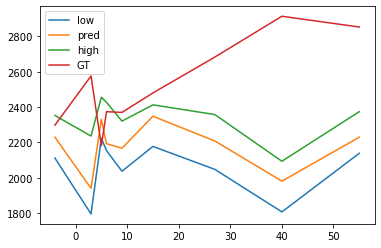

In [59]:
week = 0
plt.plot(data[1], all_preds[week][0], label='low')
plt.plot(data[1], all_preds[week][1], label='pred')
plt.plot(data[1], all_preds[week][2], label='high')
plt.plot(data[1], data[2], label='GT')
plt.legend()

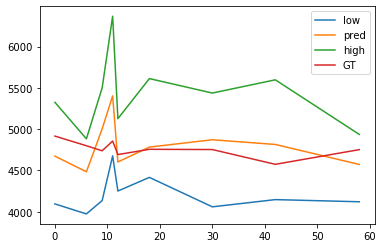

In [61]:
week = 0
plt.plot(data[1], all_preds[week][0], label='low')
plt.plot(data[1], all_preds[week][1], label='pred')
plt.plot(data[1], all_preds[week][2], label='high')
plt.plot(data[1], data[2], label='GT')
plt.legend()

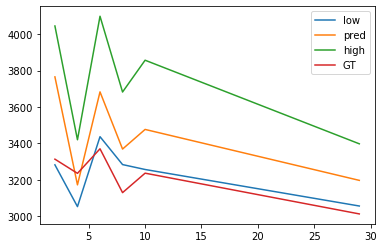

In [63]:
week = 0
plt.plot(data[1], all_preds[week][0], label='low')
plt.plot(data[1], all_preds[week][1], label='pred')
plt.plot(data[1], all_preds[week][2], label='high')
plt.plot(data[1], data[2], label='GT')
plt.legend()

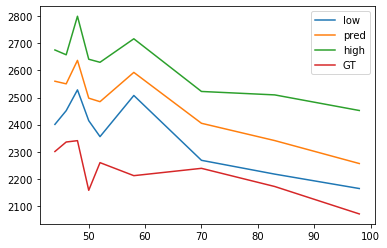

In [65]:
week = 0
plt.plot(data[1], all_preds[week][0], label='low')
plt.plot(data[1], all_preds[week][1], label='pred')
plt.plot(data[1], all_preds[week][2], label='high')
plt.plot(data[1], data[2], label='GT')
plt.legend()

In [93]:
test_all_preds = []

model.eval()
for cur_iter, data in tqdm(enumerate(test_dataset), desc='Test iter loop', leave=False):
    cur_start_time = time.time()

    FVC_true = data[2]

    with torch.no_grad():
        all_preds = model(data)

    test_all_preds.append([all_preds, FVC_true])

In [111]:
def PRINT_RESULTS(FVC_shift, metrics):
#     for metric, values in metrics.items():
#         value = np.mean(values)
#         writer.add_scalar(f'{metric}/{mode}', value, iter_num)
#     writer.add_scalar(f'sigma/{mode}', np.exp(log_sigmas.detach().mean().item()), iter_num)

    columns = [
        'FVC_shift', 
    ]

    values = [
        f'{FVC_shift}',
    ]
    
    for metric, cur_values in metrics.items():  # sorted(metrics.items(), key=lambda x: x[0]):
        columns.append(metric.replace('laplace_loss', 'll'))
        values.append(np.mean(cur_values))

#     columns += ['Sigma']
#     values += [np.exp(log_sigmas.detach().mean().item())]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='8.4f')
    if abs(FVC_shift) % 40 == 0:
        table = table.split('\n')
        table = '\n'.join([table[1]] + table)
    else:
        table = table.split('\n')[2]

    print(table)

In [114]:
ALL_METRICS = {
    'loss': {},
    'laplace_loss': {},
    'laplace_loss_70': {},
    'laplace_loss_last_3': {},
    'laplace_loss_70_last_3': {},
    'laplace_loss_first_last_3': {},
    'laplace_loss_70_first_last_3': {}
}

for FVC_shift in tqdm(range(-400, 200)):
    metrics_test = {
        'loss': [],
        'laplace_loss': [],
        'laplace_loss_70': [],
        'laplace_loss_last_3': [],
        'laplace_loss_70_last_3': [],
        'laplace_loss_first_last_3': [],
        'laplace_loss_70_first_last_3': []
    }

    for all_preds, FVC_true in test_all_preds:
        agg_metrics = {
            'loss': [],
            'laplace_loss': [],
            'laplace_loss_70': [],
            'laplace_loss_last_3': [],
            'laplace_loss_70_last_3': [],
            'laplace_loss_first_last_3': [],
            'laplace_loss_70_first_last_3': []
        }

        for FVC_LOW, FVC_PREDS, FVC_HIGH in all_preds:
            FVC_low = FVC_LOW + FVC_shift
            FVC_preds = FVC_PREDS + FVC_shift
            FVC_high = FVC_HIGH + FVC_shift

            log70 = torch.tensor(np.log(70))

            pinball_loss =  PinballLoss(0.2)(FVC_true, FVC_low)
            pinball_loss += PinballLoss(0.5)(FVC_true, FVC_preds)
            pinball_loss += PinballLoss(0.8)(FVC_true, FVC_high)

            log_sigmas = torch.log(torch.clamp_min(FVC_high - FVC_low, 1e-7))

            laplace_loss = LaplaceLoss()(FVC_true, FVC_preds, log_sigmas)

            cur_loss = 0.8 * pinball_loss + 0.2 * laplace_loss

            agg_metrics['loss'] += [cur_loss.item()]

            agg_metrics['laplace_loss'] += [LaplaceLoss()(FVC_true, FVC_preds, log_sigmas, metric=True).item()]
            agg_metrics['laplace_loss_70'] += [LaplaceLoss()(FVC_true, FVC_preds, log70, metric=True).item()]

            agg_metrics['laplace_loss_last_3'] += [LaplaceLoss()(FVC_true[-3:], FVC_preds[-3:],
                                                                 log_sigmas[-3:], metric=True).item()]
            agg_metrics['laplace_loss_70_last_3'] += [LaplaceLoss()(FVC_true[-3:], FVC_preds[-3:],
                                                                    log70, metric=True).item()]

            agg_metrics['laplace_loss_first_last_3'] += [agg_metrics['laplace_loss_last_3'][0]]
            agg_metrics['laplace_loss_70_first_last_3'] += [agg_metrics['laplace_loss_70_last_3'][0]]

        for metric, values in agg_metrics.items():
            metrics_test[metric] += [np.mean(values)]

    for metric, values in metrics_test.items():
        ALL_METRICS[metric][FVC_shift] = np.mean(values)

#     print(FVC_shift, np.mean(metrics_test['laplace_loss_last_3']), np.mean(metrics_test['laplace_loss_70_first_last_3']))

    PRINT_RESULTS(FVC_shift, metrics_test)
#     print(FVC_shift, ALL_METRICS['laplace_loss_70_first_last_3'][FVC_shift])

-----------  --------  --------  --------  -----------  --------------  -----------------  --------------------
  FVC_shift      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3
-----------  --------  --------  --------  -----------  --------------  -----------------  --------------------
       -400  375.9796   12.3733   12.3733      12.0638         12.0638            12.4492               12.4492
       -399  375.0613   12.3555   12.3555      12.0471         12.0471            12.4336               12.4336
       -398  374.1446   12.3378   12.3378      12.0303         12.0303            12.4180               12.4180
       -397  373.2299   12.3201   12.3201      12.0136         12.0136            12.4024               12.4024
       -396  372.3174   12.3024   12.3024      11.9968         11.9968            12.3868               12.3868
       -395  371.4074   12.2847   12.2847      11.9801         11.9801            12.3712               

       -332  317.2477   11.1983   11.1983      10.9641         10.9641            11.4560               11.4560
       -331  316.4463   11.1816   11.1816      10.9485         10.9485            11.4429               11.4429
       -330  315.6466   11.1650   11.1650      10.9330         10.9330            11.4297               11.4297
       -329  314.8492   11.1484   11.1484      10.9174         10.9174            11.4165               11.4165
       -328  314.0541   11.1318   11.1318      10.9019         10.9019            11.4034               11.4034
       -327  313.2612   11.1152   11.1152      10.8864         10.8864            11.3902               11.3902
       -326  312.4703   11.0986   11.0986      10.8709         10.8709            11.3770               11.3770
       -325  311.6818   11.0821   11.0821      10.8554         10.8554            11.3639               11.3639
       -324  310.8948   11.0655   11.0655      10.8399         10.8399            11.3507               

       -264  267.5017   10.1264   10.1264       9.9599          9.9599            10.6237               10.6237
       -263  266.8480   10.1118   10.1118       9.9462          9.9462            10.6129               10.6129
       -262  266.1966   10.0974   10.0974       9.9327          9.9327            10.6022               10.6022
       -261  265.5472   10.0829   10.0829       9.9192          9.9192            10.5915               10.5915
       -260  264.9006   10.0685   10.0685       9.9057          9.9057            10.5808               10.5808
       -259  264.2561   10.0541   10.0541       9.8923          9.8923            10.5701               10.5701
       -258  263.6128   10.0398   10.0398       9.8788          9.8788            10.5594               10.5594
       -257  262.9707   10.0255   10.0255       9.8654          9.8654            10.5487               10.5487
       -256  262.3301   10.0112   10.0112       9.8521          9.8521            10.5380               

       -196  228.6386    9.2302    9.2302       9.1491          9.1491            10.0063               10.0063
       -195  228.1580    9.2187    9.2187       9.1393          9.1393             9.9986                9.9986
       -194  227.6795    9.2073    9.2073       9.1296          9.1296             9.9912                9.9912
       -193  227.2038    9.1958    9.1958       9.1200          9.1200             9.9840                9.9840
       -192  226.7320    9.1844    9.1844       9.1104          9.1104             9.9770                9.9770
       -191  226.2620    9.1731    9.1731       9.1009          9.1009             9.9699                9.9699
       -190  225.7947    9.1617    9.1617       9.0914          9.0914             9.9632                9.9632
       -189  225.3311    9.1504    9.1504       9.0820          9.0820             9.9565                9.9565
       -188  224.8707    9.1392    9.1392       9.0727          9.0727             9.9497               

       -125  202.0135    8.5509    8.5509       8.6136          8.6136             9.5930                9.5930
       -124  201.7502    8.5438    8.5438       8.6088          8.6088             9.5886                9.5886
       -123  201.4904    8.5366    8.5366       8.6040          8.6040             9.5843                9.5843
       -122  201.2330    8.5295    8.5295       8.5992          8.5992             9.5800                9.5800
       -121  200.9788    8.5225    8.5225       8.5945          8.5945             9.5760                9.5760
-----------  --------  --------  --------  -----------  --------------  -----------------  --------------------
  FVC_shift      loss        ll     ll_70    ll_last_3    ll_70_last_3    ll_first_last_3    ll_70_first_last_3
-----------  --------  --------  --------  -----------  --------------  -----------------  --------------------
       -120  200.7287    8.5155    8.5155       8.5898          8.5898             9.5720               

        -57  191.7663    8.2349    8.2349       8.4832          8.4832             9.4393                9.4393
        -56  191.7380    8.2332    8.2332       8.4848          8.4848             9.4401                9.4401
        -55  191.7128    8.2315    8.2315       8.4864          8.4864             9.4409                9.4409
        -54  191.6903    8.2298    8.2298       8.4880          8.4880             9.4417                9.4417
        -53  191.6707    8.2283    8.2283       8.4898          8.4898             9.4428                9.4428
        -52  191.6543    8.2269    8.2269       8.4918          8.4918             9.4442                9.4442
        -51  191.6410    8.2255    8.2255       8.4939          8.4939             9.4456                9.4456
        -50  191.6315    8.2242    8.2242       8.4960          8.4960             9.4473                9.4473
        -49  191.6245    8.2229    8.2229       8.4982          8.4982             9.4493               

         11  197.5494    8.3067    8.3067       8.7716          8.7716             9.6802                9.6802
         12  197.7501    8.3106    8.3106       8.7784          8.7784             9.6856                9.6856
         13  197.9533    8.3146    8.3146       8.7852          8.7852             9.6910                9.6910
         14  198.1594    8.3186    8.3186       8.7922          8.7922             9.6967                9.6967
         15  198.3678    8.3228    8.3228       8.7991          8.7991             9.7023                9.7023
         16  198.5784    8.3270    8.3270       8.8062          8.8062             9.7080                9.7080
         17  198.7915    8.3312    8.3312       8.8133          8.8133             9.7137                9.7137
         18  199.0078    8.3355    8.3355       8.8204          8.8204             9.7193                9.7193
         19  199.2274    8.3399    8.3399       8.8277          8.8277             9.7248               

         81  218.8015    8.7719    8.7719       9.4102          9.4102            10.2128               10.2128
         82  219.2119    8.7813    8.7813       9.4218          9.4218            10.2228               10.2228
         83  219.6251    8.7907    8.7907       9.4335          9.4335            10.2327               10.2327
         84  220.0410    8.8002    8.8002       9.4452          9.4452            10.2427               10.2427
         85  220.4600    8.8097    8.8097       9.4569          9.4569            10.2526               10.2526
         86  220.8811    8.8192    8.8192       9.4686          9.4686            10.2626               10.2626
         87  221.3057    8.8288    8.8288       9.4804          9.4804            10.2725               10.2725
         88  221.7326    8.8385    8.8385       9.4921          9.4921            10.2825               10.2825
         89  222.1620    8.8483    8.8483       9.5039          9.5039            10.2924               

        152  254.6133    9.5701    9.5701      10.3200         10.3200            10.9596               10.9596
        153  255.2117    9.5831    9.5831      10.3338         10.3338            10.9713               10.9713
        154  255.8118    9.5962    9.5962      10.3476         10.3476            10.9829               10.9829
        155  256.4141    9.6093    9.6093      10.3615         10.3615            10.9947               10.9947
        156  257.0192    9.6224    9.6224      10.3754         10.3754            11.0067               11.0067
        157  257.6267    9.6356    9.6356      10.3893         10.3893            11.0186               11.0186
        158  258.2370    9.6487    9.6487      10.4032         10.4032            11.0306               11.0306
        159  258.8492    9.6619    9.6619      10.4171         10.4171            11.0425               11.0425
-----------  --------  --------  --------  -----------  --------------  -----------------  -------------

In [74]:
np.mean(metrics_test['laplace_loss_last_3'])

8.696535675836158

In [109]:
ALL_METRICS['laplace_loss_70_first_last_3']

{-1000: 21.600965640761636,
 -999: 21.5890274589712,
 -998: 21.577089298855174,
 -997: 21.565122615207326,
 -996: 21.553031347014688,
 -995: 21.54094019803134,
 -994: 21.52884911407124,
 -993: 21.516757824204184,
 -992: 21.50466664270921,
 -991: 21.492575255307283,
 -990: 21.480484117161144,
 -989: 21.468392913991753,
 -988: 21.456301591613077,
 -987: 21.44416459040208,
 -986: 21.431920398365367,
 -985: 21.41967611963099,
 -984: 21.407431851733815,
 -983: 21.395187648859892,
 -982: 21.382988474585794,
 -981: 21.371050292795356,
 -980: 21.35911225188862,
 -979: 21.347174200144682,
 -978: 21.335236159237947,
 -977: 21.323297944935884,
 -976: 21.311359611424532,
 -975: 21.299421364610847,
 -974: 21.28748322616924,
 -973: 21.27562217278914,
 -972: 21.263989892872896,
 -971: 21.252335927703164,
 -970: 21.2405366897583,
 -969: 21.228484240445223,
 -968: 21.21624004840851,
 -967: 21.203995953906666,
 -966: 21.191751620986246,
 -965: 21.179507537321612,
 -964: 21.167263063517485,
 -963: 21.154

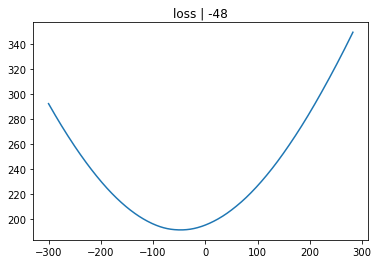

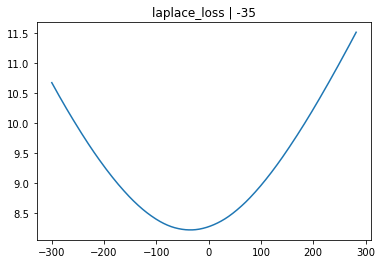

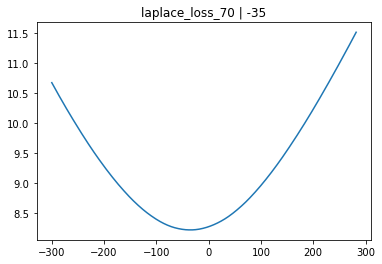

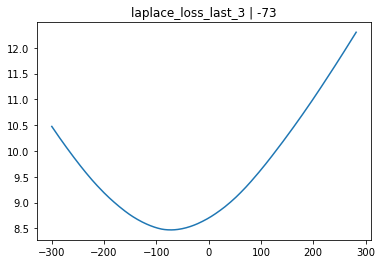

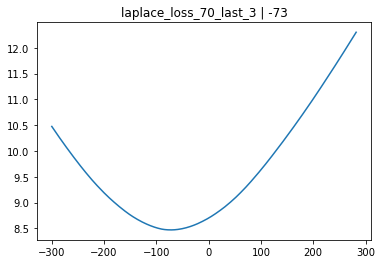

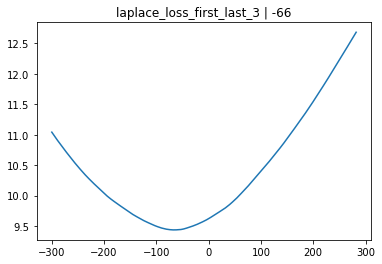

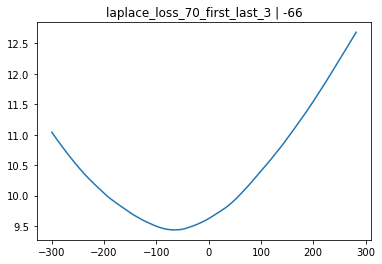

In [108]:
for k, vals in ALL_METRICS.items():
    argmin = np.argmin(list(vals.values()))
    best_FVC_shift = list(vals.keys())[argmin]
    plt.figure()
    plt.title(f'{k} | {best_FVC_shift}')
    plt.plot(list(vals.keys())[700:], list(vals.values())[700:])

In [42]:
# for g in optimizer.param_groups:
#     g['lr'] *= 2

In [12]:
# for name, p in model.named_parameters():
#     if p.requires_grad:
#         if p.grad is None:
#             print(f'Has grad but it is None: {name[20:]:50}')
#         else:
#             print(f'{name[20:]:50} : {p.grad.data.cpu().min().item():15.3e}, {p.grad.data.cpu().max().item():15.3e}')
#     else:
#         print(f'No grad: {name[20:]:50}')